In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
import time
import ta

# Fetch historical stock data
ticker = 'TSLA'
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Up to today
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the dataset
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [2]:
data['MovAvg10'] = data['Close'].rolling(window=10).mean()
data['MovAvg50'] = data['Close'].rolling(window=50).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'], window=14).rsi()


In [3]:
data = data.dropna()

In [4]:
features = ['Open', 'Close', 'MovAvg10', 'MovAvg50', 'RSI', 'Volume']
data

,Open,High,Low,Close,Adj Close,Volume,MovAvg10,MovAvg50,RSI
Date,,,,,,,,,
2010-09-08,1.377333,1.396667,1.373333,1.393333,1.393333,4326000,1.351333,1.322240,56.715667
2010-09-09,1.400000,1.403333,1.379333,1.380667,1.380667,5643000,1.356733,1.318000,55.066528
2010-09-10,1.383333,1.395333,1.317333,1.344667,1.344667,5799000,1.359533,1.313120,50.566024
2010-09-13,1.392667,1.393333,1.366667,1.381333,1.381333,5412000,1.366333,1.311467,54.632896
2010-09-14,1.369333,1.440000,1.368667,1.408000,1.408000,9820500,1.374667,1.314027,57.379217
...,...,...,...,...,...,...,...,...,...
2024-08-23,214.460007,221.479996,214.210007,220.320007,220.320007,81525200,213.503003,218.046201,52.535512
2024-08-26,218.750000,219.089996,211.009995,213.210007,213.210007,59301200,215.075003,218.661001,48.830083
2024-08-27,213.250000,215.660004,206.940002,209.210007,209.210007,62821400,215.213004,219.285001,46.828954


In [5]:
train_size = int(len(data) * 0.75)
val_size = int(len(data) * 0.10)

In [6]:
train_data = data[features].iloc[:train_size]
validation_data = data[features].iloc[train_size:train_size + val_size]
test_data = data[features].iloc[train_size + val_size:]

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)

MinMaxScaler()

In [8]:
scaled_train_data = scaler.transform(train_data)
scaled_validation_data = scaler.transform(validation_data)
scaled_test_data = scaler.transform(test_data)

In [9]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
seq_length = 120
X_train, y_train = create_sequences(scaled_train_data, seq_length)
X_val, y_val = create_sequences(scaled_validation_data, seq_length)
X_test, y_test = create_sequences(scaled_test_data, seq_length)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [12]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.0101 - mean_absolute_error: 0.0415 - val_loss: 0.0082 - val_mean_absolute_error: 0.0722
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 9.6349e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0097 - val_mean_absolute_error: 0.0727
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 8.6040e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0080 - val_mean_absolute_error: 0.0741
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 7.8663e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0142 - val_mean_absolute_error: 0.0964
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 7.7957e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0052 - val_mean_absolute_error: 0.0566
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 9.1847e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0048 - val_mean_absolute_error: 0.0509
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 5.4251e-04 - mean_abso

In [14]:
test_predictions_scaled = model.predict(X_test)
test_predictions_full = np.zeros((test_predictions_scaled.shape[0], len(features)))
test_predictions_full[:, 1] = test_predictions_scaled[:, 0]
test_predictions = scaler.inverse_transform(test_predictions_full)[:, 1]

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [15]:
y_test_full = np.zeros((y_test.shape[0], len(features)))
y_test_full[:, 1] = y_test
y_test_actual = scaler.inverse_transform(y_test_full)[:, 1]

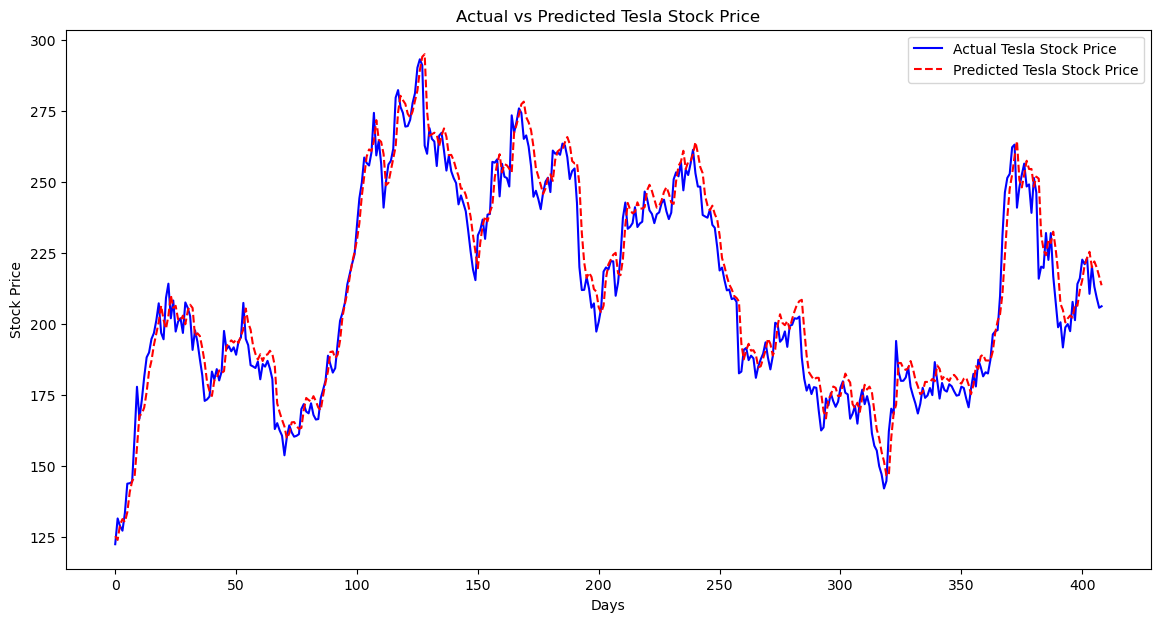

In [16]:
# Plotting the Actual vs Predicted values
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(y_test_actual, color='blue', label='Actual Tesla Stock Price')

# Plot predicted values
plt.plot(test_predictions, color='red', linestyle='--', label='Predicted Tesla Stock Price')

plt.title('Actual vs Predicted Tesla Stock Price')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [17]:
test_predictions

array([125.25532648, 123.91286402, 129.3442351 , 131.26866886,
       130.24743736, 133.68478337, 140.75125326, 144.65533616,
       146.10728616, 156.53291664, 167.73697762, 168.32621547,
       170.62482479, 176.09983018, 183.39357228, 187.11590379,
       192.61012364, 196.73291959, 200.74511008, 206.46861094,
       201.46526833, 198.32637541, 202.96937687, 210.15202442,
       205.73067057, 206.43157942, 201.69519564, 201.21013514,
       202.97863475, 199.92215443, 204.65549882, 206.81581637,
       205.68469559, 195.75664995, 196.76083297, 195.81261646,
       191.60740791, 186.45646325, 179.48150664, 176.35260523,
       174.65633455, 180.16112236, 181.0480622 , 183.68273255,
       182.78094517, 183.38745858, 192.12480112, 193.17373639,
       194.25910927, 193.49605035, 194.56231357, 193.38258018,
       195.89866234, 198.14088592, 205.48993076, 200.48882402,
       198.04830712, 192.5021034 , 189.49619206, 187.47308327,
       189.34872975, 186.99003155, 189.11406869, 189.28

In [18]:
last_sequence = scaled_test_data[-seq_length:]
next_date = datetime.today() + timedelta(days=1)


In [19]:
while next_date.weekday() >= 5:
    next_date += timedelta(days=1)

In [20]:
prediction_scaled = model.predict(np.reshape(last_sequence, (1, seq_length, len(features))))
prediction_full = np.zeros((1, len(features)))
prediction_full[0, 1] = prediction_scaled[0, 0]  # 'Close' price
predicted_price = scaler.inverse_transform(prediction_full)[0, 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [21]:
print(f"Predicted close price for {next_date.strftime('%Y-%m-%d')}: {predicted_price:.2f}")


Predicted close price for 2024-09-02: 212.94
